# E-CVRP (Electric Capacitated Vehicle Routing Problem)

The Electric Capacitated Vehicle Routing Problem (E-CVRP) is an extension of the classical Vehicle Routing Problem (VRP) that addresses the specific challenges of routing electric vehicles. This implementation uses Ant Colony Optimization (ACO) to solve the E-CVRP.

### Problem Description
The E-CVRP involves finding optimal routes for a fleet of electric vehicles while considering:

- Limited battery capacity and energy consumption
- Limited cargo capacity for customer deliveries
- The need for recharging at charging stations
- Returning to depot for restocking
- Service of all customer demands

### Key Features

- Battery Management: Routes consider battery consumption based on distance traveled
- Charging Stations: Vehicles can recharge at designated charging stations
- Cargo Constraints: Each vehicle has a maximum cargo capacity
- Safe Returns: Ensures vehicles can safely return to depot without depleting battery
- ACO Implementation: Uses ant colony optimization with:

### Pheromone trails for route learning
- Probabilistic node selection
- Evaporation and reinforcement mechanics

### Implementation Details

- Parses E-CVRP benchmark instance files
- Creates distance matrices for route calculations
- Implements ant colony optimization with:
    - Multiple generations of ant populations
    - Pheromone update mechanisms
    - Route construction considering both battery and cargo constraints
- Visualizes final routes using matplotlib

Finding Best Route...


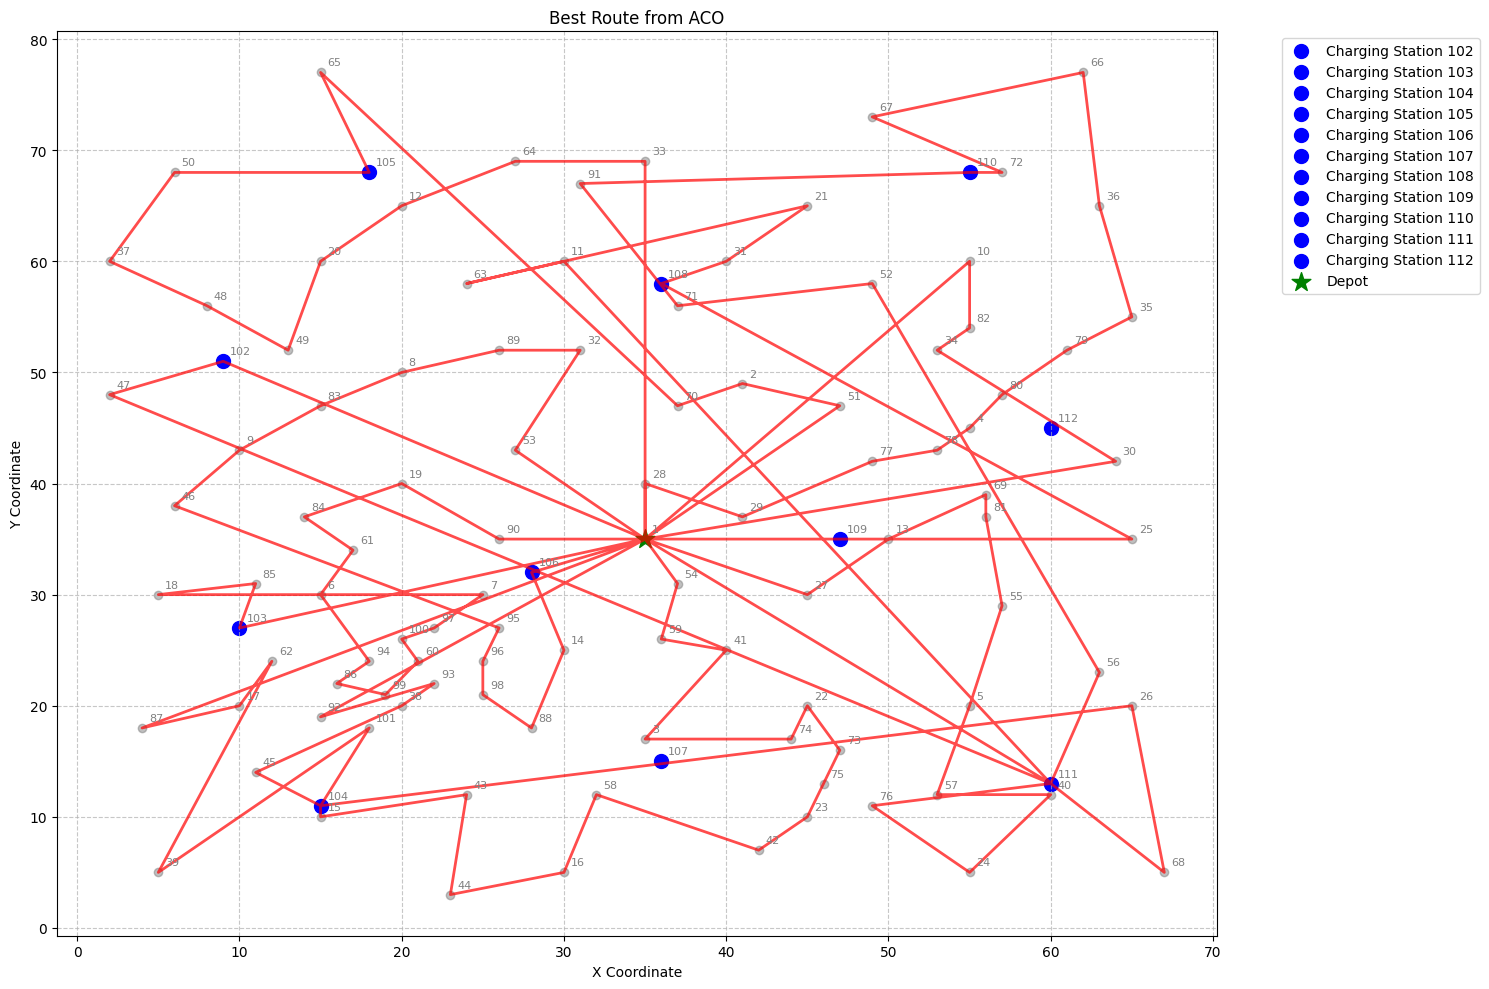

Best Route: [1, 54, 59, 41, 3, 74, 22, 73, 75, 23, 42, 58, 16, 44, 43, 15, 104, 45, 38, 93, 92, 1, 28, 29, 77, 78, 4, 80, 79, 35, 36, 66, 67, 72, 110, 91, 71, 52, 56, 111, 1, 90, 19, 84, 61, 6, 94, 86, 99, 60, 100, 97, 7, 18, 85, 103, 1, 27, 13, 69, 81, 55, 5, 57, 40, 24, 76, 111, 47, 102, 1, 53, 32, 89, 8, 83, 9, 46, 95, 96, 98, 88, 14, 106, 1, 33, 64, 12, 20, 49, 48, 37, 50, 105, 65, 70, 2, 51, 1, 87, 17, 62, 39, 101, 104, 26, 68, 111, 11, 63, 21, 31, 108, 25, 1, 10, 82, 34, 30, 1]
Route Quality: 1373.0675551565973


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ACO Hyperparameters
ALPHA = 1  # Pheromone importance
BETA = 2   # Distance importance
EVAPORATION_RATE = 0.5
PHEROMONE_DEPOSIT = 1.0
DEBUG = False

def parse_evrp_data(file_path):
    with open(file_path, 'r') as file:
        content = file.readlines()

    coordinates, demands, station_coords, depots = [], [], [], []
    params = {
        "DIMENSION": (int, "dimension"),
        "CAPACITY": (int, "cargo_capacity"),
        "ENERGY_CAPACITY": (int, "battery_capacity"),
        "ENERGY_CONSUMPTION": (float, "energy_consumption"),
        "STATIONS": (int, "num_stations"),
        "VEHICLES": (int, "num_vehicles")
    }
    data = {param: 0 for param in params.values()}

    reading_section = None
    for line in content:
        line = line.strip()
        if ":" in line:
            key, value = line.split(":")
            if key in params:
                parse_type, param_name = params[key]
                data[param_name] = parse_type(value.strip())
        elif "EOF" in line:
            break
        elif "SECTION" in line:
            reading_section = line.split()[0]
        else:
            if reading_section == "NODE_COORD_SECTION":
                node_id, x, y = map(float, line.split())
                coordinates.append((x, y))
            elif reading_section == "DEMAND_SECTION":
                node_id, demand = map(int, line.split())
                demands.append((node_id - 1, demand))
            elif reading_section == "STATIONS_COORD_SECTION":
                station_id = int(line) - 1
                station_coords.append(station_id)
            elif reading_section == "DEPOT_SECTION" and int(line) != -1:
                depots.append(int(line) - 1)  # Convert to 0-based indexing

    data.update({
        "coordinates": coordinates,
        "demands": demands,
        "station_coords": station_coords,
        "depots": depots
    })

    return data

def euclidean_distance(point1, point2):
    return np.sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)))

def create_distance_matrix(coordinates):
    num_nodes = len(coordinates)
    dist_mat = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                dist_mat[i][j] = euclidean_distance(coordinates[i], coordinates[j])
            else:
                dist_mat[i][j] = float("inf")

    return dist_mat

class EV_Ant:
    def __init__(self, dimensions, dist_mat, battery_capacity, cargo_capacity, charging_stations, demands, depots, energy_consumption):
        self.dimensions = dimensions
        self.dist_mat = dist_mat
        self.battery_capacity = battery_capacity
        self.cargo_capacity = cargo_capacity
        self.charging_stations = charging_stations
        self.demands = demands
        self.depots = depots
        self.energy_consumption_rate = energy_consumption
        
        self.pheromone_trails = np.ones((dimensions, dimensions)) * 0.1
        self.reset()

    def reset(self):
        self.position = np.random.permutation(self.dimensions)
        self.x_ij = np.zeros((self.dimensions, self.dimensions))
        self.current_battery = self.battery_capacity
        self.current_cargo = self.cargo_capacity
        self.quality = float("inf")
        self.route = []

    def recharge_battery(self):
        self.current_battery = self.battery_capacity

    def visit_node(self, current_node, next_node):
        # Calculate battery consumption
        battery_consumption = self.calculate_battery_consumption(current_node, next_node)
        self.current_battery -= battery_consumption

        # Update cargo for customer nodes
        if next_node not in self.depots and next_node not in self.charging_stations:
            self.current_cargo -= self.demands[next_node][1]

        # Mark the edge as visited and update route
        self.x_ij[current_node][next_node] = 1
        self.route.append(next_node)

        if DEBUG:
            print(f"Visited node {next_node+1}")
            print(f"Battery: {self.current_battery}, Cargo: {self.current_cargo}")

    def calculate_battery_consumption(self, from_node, to_node):
        distance = self.dist_mat[from_node][to_node]
        energy_consumption = distance * self.energy_consumption_rate
        return energy_consumption

    def can_visit_next_node(self, current_node, next_node):
        # Skip invalid nodes
        if next_node < 0 or next_node >= len(self.demands):
            return False
    
        # Calculate battery needed to visit next node
        battery_needed_to_next = self.calculate_battery_consumption(current_node, next_node)
        
        # Check battery and cargo constraints
        sufficient_battery_to_next = self.current_battery >= battery_needed_to_next
        
        # Find safe return points (depots and charging stations)
        safe_points = set(self.depots + self.charging_stations)
        
        # Ensure that it can reach a safe point after visiting next node
        can_safely_return = any(
            self.current_battery - battery_needed_to_next >= 
            self.calculate_battery_consumption(next_node, safe_point)
            for safe_point in safe_points
        )
    
        # Check cargo constraints
        can_service_demand = (
            next_node in self.charging_stations or 
            next_node in self.depots or 
            self.current_cargo >= self.demands[next_node][1]
        )
    
        return (
            sufficient_battery_to_next and 
            can_safely_return and 
            can_service_demand
        )

    def can_safely_reach_charging_point(self, current_node, remaining_nodes):
        """
        Check if ant can safely reach a charging station or depot from current location
        """
        # Combine charging stations and depots as safe points
        safe_points = set(self.charging_stations + self.depots)
        
        # Find nearest safe point with sufficient battery margin
        for safe_point in safe_points:
            battery_needed = self.calculate_battery_consumption(current_node, safe_point)
            if self.current_battery >= battery_needed:
                return True
        
        return False
    
    def find_nearest_safe_point(self, current_node):
        """
        Find the nearest depot or charging station
        """
        safe_points = self.charging_stations + self.depots
        return min(
            safe_points, 
            key=lambda point: self.dist_mat[current_node][point]
        )

    def route_construction(self, number_of_nodes, dist_mat, pheromone_mat):
        # Reset ant's state
        self.reset()
        
        # Start from depot (first node)
        current_node = self.depots[0]
        self.route = [current_node]
        
        # Track remaining demands (already zero-indexed)
        remaining_demands = {node: demand for node, demand in self.demands if node not in self.depots and node not in self.charging_stations}
        visited_nodes = set([current_node])
        
        max_iterations = number_of_nodes * 2  # Prevent infinite loops
        iterations = 0
        
        while remaining_demands and iterations < max_iterations:
            iterations += 1
            
            # Always check battery safety before any further routing
            safe_points = self.depots + self.charging_stations
            
            # Check if ant can safely reach any safe point
            can_reach_safe_point = False
            for safe_point in safe_points:
                battery_needed = self.calculate_battery_consumption(current_node, safe_point)
                if self.current_battery >= battery_needed:
                    can_reach_safe_point = True
                    break
            
            # If cannot reach any safe point, go to nearest safe point
            if not can_reach_safe_point:
                nearest_safe_point = min(
                    safe_points, 
                    key=lambda point: self.dist_mat[current_node][point]
                )
                self.visit_node(current_node, nearest_safe_point)
                
                # Fully recharge at safe point
                if nearest_safe_point in self.charging_stations:
                    self.recharge_battery()
                elif nearest_safe_point in self.depots:
                    self.current_battery = self.battery_capacity
                
                current_node = nearest_safe_point
                continue

            # Check cargo and return to depot if needed
            if not any(self.current_cargo >= demand for node, demand in remaining_demands.items()):
                depot_node = self.depots[0]
                battery_needed_to_depot = self.calculate_battery_consumption(current_node, depot_node)
                
                # If we can't safely return to depot, visit charging stations until we can
                while self.current_battery < battery_needed_to_depot:
                    # Find nearest charging station
                    nearest_station = min(
                        self.charging_stations,
                        key=lambda station: self.dist_mat[current_node][station]
                    )
                    
                    # Visit the charging station
                    self.visit_node(current_node, nearest_station)
                    self.recharge_battery()
                    current_node = nearest_station
                    
                    # Recalculate battery needed from new position
                    battery_needed_to_depot = self.calculate_battery_consumption(current_node, depot_node)
                
                # Now we can safely return to depot
                self.visit_node(current_node, depot_node)
                self.current_cargo = self.cargo_capacity  # Restock cargo
                self.current_battery = self.battery_capacity  # Recharge at depot
                current_node = depot_node
                continue
            
            # Find feasible nodes
            feasible_nodes = []
            for next_node, demand in remaining_demands.items():
                if (next_node not in visited_nodes and 
                    self.current_cargo >= demand and 
                    self.can_visit_next_node(current_node, next_node)):
                    
                    # Probabilistic selection with pheromone and distance
                    pheromone = pheromone_mat[current_node][next_node]
                    visibility = 1 / (dist_mat[current_node][next_node] + 1e-10)
                    feasible_nodes.append((next_node, pheromone ** ALPHA * visibility ** BETA))
            
            # No feasible nodes found
            if not feasible_nodes:
                # Go to nearest safe point
                nearest_safe_point = min(
                    safe_points, 
                    key=lambda point: self.dist_mat[current_node][point]
                )
                self.visit_node(current_node, nearest_safe_point)
                
                # Recharge if at charging station
                if nearest_safe_point in self.charging_stations:
                    self.recharge_battery()
                # Fully recharge if at depot
                elif nearest_safe_point in self.depots:
                    self.current_battery = self.battery_capacity
                
                current_node = nearest_safe_point
                continue
            
            # Normalize and select next node
            total = sum(prob for _, prob in feasible_nodes)
            probabilities = [prob/total for _, prob in feasible_nodes]
            next_node = random.choices(
                [node for node, _ in feasible_nodes], 
                weights=probabilities
            )[0]
            
            # Visit the node
            self.visit_node(current_node, next_node)
            del remaining_demands[next_node]
            visited_nodes.add(next_node)
            current_node = next_node
        
        # Ensure safe return to depot
        depot_node = self.depots[0]
        if current_node != depot_node:
            # Check if we can safely return to depot
            battery_needed_to_depot = self.calculate_battery_consumption(current_node, depot_node)
            
            # If we can't safely return to depot, visit charging stations until we can
            while self.current_battery < battery_needed_to_depot:
                # Find nearest charging station
                nearest_station = min(
                    self.charging_stations,
                    key=lambda station: self.dist_mat[current_node][station]
                )
                
                # Visit the charging station
                self.visit_node(current_node, nearest_station)
                self.recharge_battery()
                current_node = nearest_station
                
                # Recalculate battery needed from new position
                battery_needed_to_depot = self.calculate_battery_consumption(current_node, depot_node)
            
            # Now we can safely return to depot
            self.visit_node(current_node, depot_node)
            self.current_battery = self.battery_capacity  # Recharge at final depot visit
        
        # Calculate route quality (total distance)
        self.quality = sum(
            dist_mat[self.route[i]][self.route[i+1]] 
            for i in range(len(self.route)-1)
        )

def update_pheromones(pheromone_mat, ants, evaporation_rate=0.5, Q=100):
    # Evaporate existing pheromones
    pheromone_mat *= (1 - evaporation_rate)
    
    # Deposit pheromones based on ant solutions
    for ant in ants:
        for i in range(len(ant.route)-1):
            from_node, to_node = ant.route[i], ant.route[i+1]
            pheromone_mat[from_node][to_node] += Q / ant.quality
    
    return pheromone_mat                    

def plot_evpr_route(coordinates, route, charging_stations, title="Electric Vehicle Routing Problem Route"):
    # Convert coordinates to numpy array
    coords = np.array(coordinates)
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    
    # Plot all nodes
    plt.scatter(coords[:, 0], coords[:, 1], c='gray', alpha=0.5)
    
    # Label all nodes
    for i, (x, y) in enumerate(coords):
        plt.annotate(str(i+1), (x, y), xytext=(5, 5), 
                     textcoords='offset points', fontsize=8, color='gray')
    
    # Plot charging stations with unique labels
    for station in charging_stations:
        plt.scatter(coordinates[station][0], coordinates[station][1], 
                    c='blue', s=100, marker='o', 
                    label=f'Charging Station {station+1}')
    
    # Plot the route
    route_coords = [coordinates[node] for node in route]
    route_coords = np.array(route_coords)
    
    plt.plot(route_coords[:, 0], route_coords[:, 1], 'r-', linewidth=2, alpha=0.7)
    
    # Highlight start/end depot
    depot = coordinates[route[0]]
    plt.scatter(depot[0], depot[1], c='green', s=200, marker='*', label='Depot')
    
    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
def ant_colony_optimization_evrp(file_path, num_generations=20, population_size=10, plot=True):
    # Parse problem data
    parsed_data = parse_evrp_data(file_path)
    energy_consumption = parsed_data['energy_consumption']
    coordinates = parsed_data['coordinates']
    demands = parsed_data['demands']
    stations = parsed_data['station_coords']
    depots = parsed_data['depots']
    dimensions = parsed_data['dimension']
    battery_capacity = parsed_data['battery_capacity']
    cargo_capacity = parsed_data['cargo_capacity']

    # Initialize pheromone matrix
    pheromone_mat = np.ones((dimensions, dimensions)) * 1.0
    # Create distance matrix
    dist_mat = create_distance_matrix(coordinates)
    
    # Initialize global pheromone trails
    global_pheromones = np.ones((dimensions, dimensions)) * 0.1
    
    # Initialize population
    population = [
        EV_Ant(dimensions, dist_mat, battery_capacity, cargo_capacity, stations, demands, depots, energy_consumption) 
        for _ in range(population_size)
    ]
    
    # Best solution tracking
    gbest = None
    
    for j in range(num_generations):
        
        if DEBUG: print(f"\nGeneration {j+1}\n")
        
        for ant in population:
            ant.route_construction(dimensions, dist_mat, pheromone_mat)
    
        # Find the best solution in this generation
        iter_best = min(population, key=lambda ant: ant.quality)
        
        # Update the global best solution
        if gbest is None or iter_best.quality < gbest.quality:
            gbest = iter_best
    
        # Update pheromones
        update_pheromones(pheromone_mat, population)

    # Plot the best route if requested
    if plot:
        # Filter out any nodes outside the valid range
        valid_route = [node for node in gbest.route if 0 <= node < len(coordinates)]
        plot_evpr_route(coordinates, valid_route, stations, title="Best Route from ACO")
    
    return valid_route, gbest.quality

"""
Solve the problem
"""
# Set the path for E-CVRP data
# file_path = "e-cvrp_benchmark_instances-master/E-n35-k3-s5.evrp"
file_path = "e-cvrp_benchmark_instances-master/E-n112-k8-s11.evrp"
# file_path = "e-cvrp_benchmark_instances-master/X-n469-k26-s10.evrp"
print(f"Finding Best Route...")
best_route, best_quality = ant_colony_optimization_evrp(file_path, num_generations=20, population_size=10, plot=True)
best_route = list(map(lambda a: (a+1), best_route))
print(f"Best Route: {best_route}")
print(f"Route Quality: {best_quality}")